# 2 - Exploratory Analysis

### Imports and Processed Data Fetch

In [1]:
import pandas as pd
import pathlib
import os
import pickle
import matplotlib.pyplot as plt

**Obs:** Just run the followin cell *once* as it alters the working directory path.

In [2]:
# Setting project root directory to work with scripts folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
os.chdir(project_root)

print("Current Working Directory:", os.getcwd())    

Current Working Directory: /home/gabrielhso/Desktop/northumbria/data-analytics/project-repo


In [3]:
DATA_DIR = pathlib.Path.cwd() / 'data'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
with open(PROCESSED_DATA_DIR / 'data_df.pkl', 'rb') as f:
    data_df = pickle.load(f)

data_df.head()

,Dst Port,Protocol,Timestamp,Tot Fwd Pkts,Tot Bwd Pkts,SYN Flag Cnt,ACK Flag Cnt,RST Flag Cnt,Malicious,FTP-BruteForce,SSH-Bruteforce
0,0,0,2018-02-14 08:31:01,3,0,0,0,0,0,0,0
1,0,0,2018-02-14 08:33:50,3,0,0,0,0,0,0,0
2,0,0,2018-02-14 08:36:39,3,0,0,0,0,0,0,0
3,22,6,2018-02-14 08:40:13,15,10,0,0,0,0,0,0
4,22,6,2018-02-14 08:40:23,14,11,0,0,0,0,0,0


### Exploratory Analysis and Additional Data Processing

Let's use timestamp as an index

In [4]:
# Use Timestamp as index
data_df.set_index('Timestamp', inplace=True)

**Dst Port**

Refers to destined port of the protocol. We are interested in a range of ports, as the SSH protocol uses an ephemeral port to send back ACK and RST flags. To comunicate with the server, port 22 is used. For server responses, ephemeral port range depends on the OS:
 - **Linux**: 32768–60999 (default) \
 - **Windows**: 49152–65535 (for modern Windows versions)

I opted to use a range that encompasses both limits, as the servers can be both Linux and Windows based.

In [5]:
data_df['Dst Port'].value_counts()

Dst Port
53       198162
21       193428
22       187881
80       130899
443       92119
          ...  
24693         1
20477         1
2738          1
6884          1
1924          1
Name: count, Length: 18567, dtype: int64

In [6]:
print(data_df.size)
data_df = data_df[(data_df['Dst Port'] == 22) | 
                  ((data_df['Dst Port'] >= 32768) & (data_df['Dst Port'] <= 60999))
                ]
print(data_df.size)

10485750
2718750


**Flags**

As we are only interested on SSH login attempts, we can also discard packets without SYN, ACK or RST flags

In [7]:
print(data_df.size)
data_df = data_df[(data_df['SYN Flag Cnt'] > 0) | (data_df['ACK Flag Cnt'] > 0) | (data_df['RST Flag Cnt'] > 0)]
print(data_df.size)

2718750
1746500


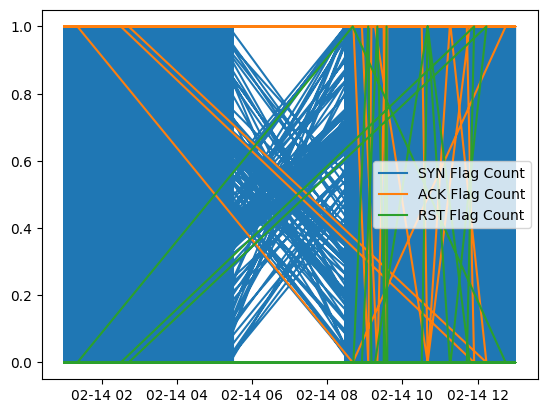

In [8]:
timestamps = data_df.index
syn_flags = data_df['SYN Flag Cnt']
ack_flags = data_df['ACK Flag Cnt']
rst_flags = data_df['RST Flag Cnt']

plt.plot(timestamps, syn_flags, label='SYN Flag Count')
plt.plot(timestamps, ack_flags, label='ACK Flag Count')
plt.plot(timestamps, rst_flags, label='RST Flag Count')
plt.legend()
plt.show()


In [9]:
syn_flags

Timestamp
2018-02-14 02:02:29    0
2018-02-14 02:02:29    0
2018-02-14 02:02:37    0
2018-02-14 02:02:55    0
2018-02-14 02:04:27    0
                      ..
2018-02-14 10:53:27    1
2018-02-14 10:53:28    0
2018-02-14 10:53:28    1
2018-02-14 10:53:28    0
2018-02-14 10:53:31    0
Name: SYN Flag Cnt, Length: 174650, dtype: int64

In [10]:
# Group and sum the flags by 1 minute
data_df = data_df.resample('min').sum()
data_df.head()

,Dst Port,Protocol,Tot Fwd Pkts,Tot Bwd Pkts,SYN Flag Cnt,ACK Flag Cnt,RST Flag Cnt,Malicious,FTP-BruteForce,SSH-Bruteforce
Timestamp,,,,,,,,,,
2018-02-14 01:00:00,12981170,1512,499,173,48,252,0,0,0,0
2018-02-14 01:01:00,11384441,1326,344,152,10,221,0,0,0,0
2018-02-14 01:02:00,9765730,1128,345,94,5,188,0,0,0,0
2018-02-14 01:03:00,11618860,1356,482,113,23,226,0,0,0,0
2018-02-14 01:04:00,5113115,594,180,44,10,99,0,0,0,0


In [15]:
print(data_df.index.min(), data_df.index.max())

2018-02-14 01:00:00 2018-02-14 12:59:00


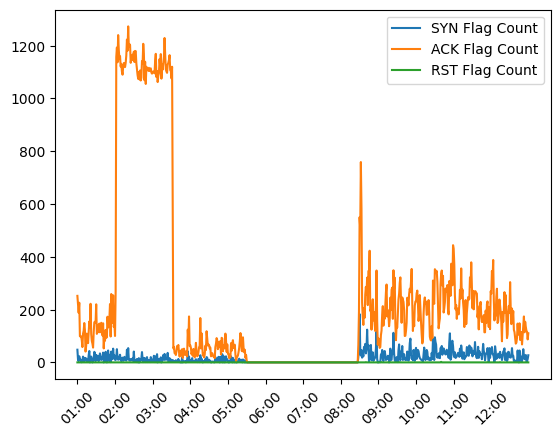

In [22]:
timestamps = data_df.index
syn_flags = data_df['SYN Flag Cnt']
ack_flags = data_df['ACK Flag Cnt']
rst_flags = data_df['RST Flag Cnt']

plt.plot(timestamps, syn_flags, label='SYN Flag Count')
plt.plot(timestamps, ack_flags, label='ACK Flag Count')
plt.plot(timestamps, rst_flags, label='RST Flag Count')

# Reprocess x axis to show every hour
plt.xticks(pd.date_range(start=timestamps.min(), end=timestamps.max(), freq='h'))
plt.xticks(rotation=45)

# Reprocess x axis labels to show only hour
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

plt.legend()
plt.show()


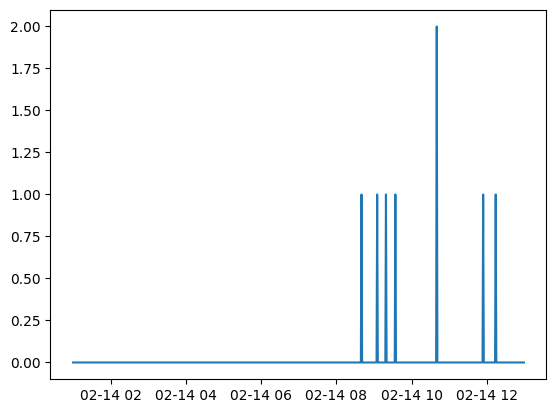

In [12]:
plt.plot(timestamps, rst_flags)